<a href="https://colab.research.google.com/github/gibiee/Measure_BoneAge/blob/master/%EB%BC%88%20%EB%82%98%EC%9D%B4%20%EC%B8%A1%EC%A0%95(Male%20%EC%A0%84%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 구글 코랩에서 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf

male_model = tf.keras.applications.InceptionV3(weights=None, include_top=True, input_shape=(224,224,1), classes=1, classifier_activation=None)


In [4]:
male_model.compile(loss='mae', optimizer='adam')

In [5]:
import pandas as pd

csv_train=pd.read_csv('/content/drive/Shareddrives/growthPrediction/machineLearning/boneage-training-dataset.csv')
csv_train.head()

,id,boneage,male
0,1377,180,False
1,1378,18,False
2,1379,94,False
3,1380,156,True
4,1381,82,False


In [6]:
for i in range(len(csv_train['id'])):
  csv_train.loc[i,"id"] = f"{csv_train['id'][i]}.png"

csv_train.head()

,id,boneage,male
0,1377.png,180,False
1,1378.png,18,False
2,1379.png,94,False
3,1380.png,156,True
4,1381.png,82,False


In [7]:
male_df = csv_train.loc[csv_train.male == True]
male_df.head()

,id,boneage,male
3,1380.png,156,True
5,1382.png,138,True
6,1383.png,150,True
7,1384.png,156,True
8,1385.png,36,True


In [7]:
len(male_df)

6506

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # random으로 validation 뽑음

train_generator = datagen.flow_from_dataframe(male_df, directory='/content/drive/Shareddrives/growthPrediction/machineLearning/dataset/boneage-training-dataset/boneage-training-dataset', x_col='id', y_col='boneage',
                                              target_size=(224,224), color_mode='grayscale',
                                              class_mode='raw', subset='training')
valid_generator = datagen.flow_from_dataframe(male_df, directory='/content/drive/Shareddrives/growthPrediction/machineLearning/dataset/boneage-training-dataset/boneage-training-dataset', x_col='id', y_col='boneage',
                                              target_size=(224,224), color_mode='grayscale', 
                                              class_mode='raw', subset='validation', shuffle=False)


Found 5205 validated image filenames.
Found 1301 validated image filenames.


In [9]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True,
                                                filepath="/content/drive/Shareddrives/growthPrediction/machineLearning/model_f")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


history = male_model.fit_generator(train_generator, validation_data=valid_generator, epochs=100, callbacks=[checkpoint, early_stopping])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
  3/163 [..............................] - ETA: 13:08 - loss: 127.8278

KeyboardInterrupt: ignored

In [ ]:
# 학습 과정에서의 loss와 val_loss 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

NameError: ignored

In [9]:
csv_test=pd.read_csv('/content/drive/Shareddrives/growthPrediction/machineLearning/boneage-test-dataset.csv')
csv_test.head()

for i in range(len(csv_test['id'])) :
  csv_test.loc[i,"id"] = f"{csv_test['id'][i]}.png"

test_df = csv_test.loc[csv_test.male == True]
test_df.head()
len(test_df)

testDatagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_generator = testDatagen.flow_from_dataframe(test_df, directory='/content/drive/Shareddrives/growthPrediction/machineLearning/dataset/boneage-test-dataset', 
                                              x_col='id', y_col='boneage',
                                              target_size=(224,224), color_mode='grayscale',
                                              class_mode='raw')

Found 324 validated image filenames.


In [10]:
# 예측값과 정답값을 비교
load_model = tf.keras.models.load_model("/content/drive/Shareddrives/growthPrediction/machineLearning/check_point_m")

import numpy as np

def changeYear(ARR) :
  NewARR = []
  for num in ARR :  
    year = num / 12
    remainder = year % 1
    
    if remainder <= 0.25 :
      remainder = 0
      NewARR.append(int(year) + remainder)
    elif remainder <= 0.75 :
      remainder = 0.5
      NewARR.append(int(year) + remainder)
    else :
      remainder = 1
      NewARR.append(int(year) + remainder)
  return NewARR

predict = load_model.predict_generator(test_generator).flatten()
predict_year = changeYear(predict)
answer_year = changeYear(test_generator.labels)

mae_month = [abs(predict[i] - test_generator.labels[i]) for i in range(len(predict))]
mae_year = [abs(predict_year[i] - answer_year[i]) for i in range(len(predict_year))]

compare = pd.DataFrame({"id" : test_generator.filenames,
                        "예측(개월)" : predict,
                        "정답(개월)" : test_generator.labels,
                        "예측(년)" : predict_year,
                        "정답(년)" : answer_year ,
                        "mae(년)" : mae_year})

total_mae_month = np.mean(mae_month)
total_mae_year = np.mean(mae_year)

compare.head(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


,id,예측(개월),정답(개월),예측(년),정답(년),mae(년)
0,14931.png,151.697937,84,12.5,7.0,5.5
1,14932.png,113.459450,138,9.5,11.5,2.0
2,14933.png,73.604652,192,6.0,16.0,10.0
3,14934.png,157.039398,156,13.0,13.0,0.0
4,14935.png,171.200745,156,14.5,13.0,1.5
...,...,...,...,...,...,...
95,15128.png,176.481506,132,14.5,11.0,3.5
96,15129.png,145.595917,72,12.0,6.0,6.0
97,15130.png,94.136375,108,8.0,9.0,1.0
98,15132.png,161.306320,168,13.5,14.0,0.5


In [11]:
print(total_mae_month, total_mae_year)

45.66415892118289 3.802469135802469


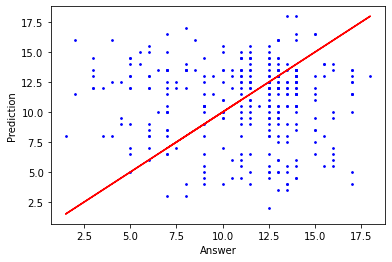

In [12]:
# 최종 결과값과 예측값 비교 시각화
import matplotlib.pyplot as plt

plt.scatter(answer_year, predict_year, color='b', s=3)
plt.plot(answer_year, answer_year, 'r')
plt.xlabel("Answer")
plt.ylabel("Prediction")
plt.show()